In [1]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 5.0 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=48c7bcf4e3cda28382b745dca49cf8902c8d17e043a5a07cee90d8e8798668bd
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-nnd30a3s
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-nnd30a3s
     |████████████████████████████████| 50 kB 3.0 MB/s 
     |████████████████████████████████| 79 kB 

In [2]:
!git clone https://github.com/facebookresearch/detectron2

Cloning into 'detectron2'...
remote: Enumerating objects: 14407, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 14407 (delta 5), reused 7 (delta 2), pack-reused 14392
Receiving objects: 100% (14407/14407), 5.90 MiB | 25.07 MiB/s, done.
Resolving deltas: 100% (10417/10417), done.


In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.11 ; cuda:  cu113
detectron2: 0.6


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
!gdown 1etRoFndzleUtHbzDUqJOZkjDRlItDAnD

Downloading...
From: https://drive.google.com/uc?id=1etRoFndzleUtHbzDUqJOZkjDRlItDAnD
To: /content/train_pill.zip
100% 52.1M/52.1M [00:01<00:00, 49.7MB/s]


In [6]:
!unzip 'train_pill.zip' -d '/content/'

Archive:  train_pill.zip
   creating: /content/train_pill/
  inflating: /content/train_pill/2.jpg  
  inflating: /content/train_pill/label.json  
   creating: /content/train_pill/pill_images/
  inflating: /content/train_pill/pill_images/0.jpg  
  inflating: /content/train_pill/pill_images/100.jpg  
  inflating: /content/train_pill/pill_images/107.jpg  
  inflating: /content/train_pill/pill_images/11.jpg  
  inflating: /content/train_pill/pill_images/118.jpg  
  inflating: /content/train_pill/pill_images/1214.jpg  
  inflating: /content/train_pill/pill_images/124.jpg  
  inflating: /content/train_pill/pill_images/128.jpg  
  inflating: /content/train_pill/pill_images/1284.jpg  
  inflating: /content/train_pill/pill_images/13.jpg  
  inflating: /content/train_pill/pill_images/1302.jpg  
  inflating: /content/train_pill/pill_images/1317.jpg  
  inflating: /content/train_pill/pill_images/14.jpg  
  inflating: /content/train_pill/pill_images/1418.jpg  
  inflating: /content/train_pill/pill_

In [8]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("pill-instance-segment", {}, "/content/train_pill/label.json", "/content/train_pill/pill_images")
dataset_dicts = DatasetCatalog.get("pill-instance-segment")
pill_metadata = MetadataCatalog.get("pill-instance-segment")

WARNING [07/07 12:09:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/07 12:09:42 d2.data.datasets.coco]: Loaded 299 images in COCO format from /content/train_pill/label.json


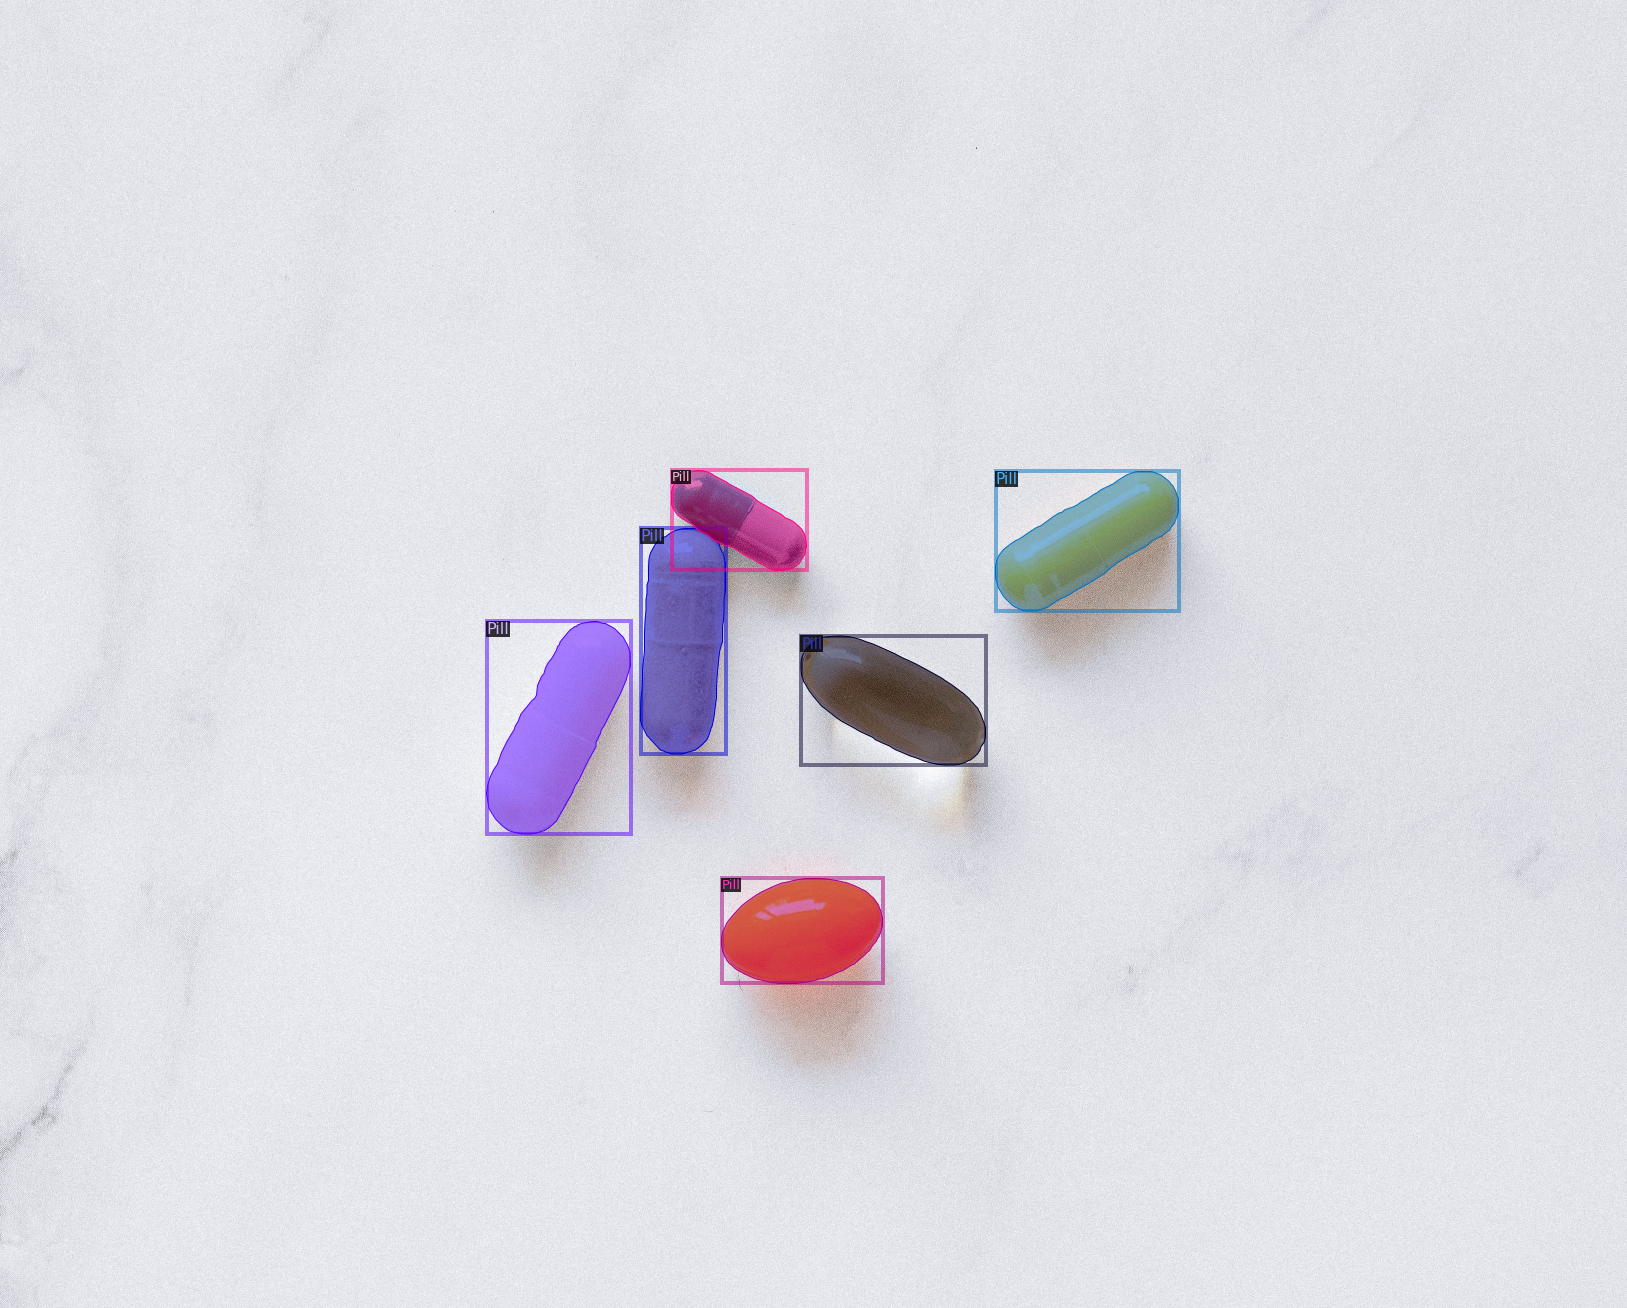

In [68]:
import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=pill_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(
     "/content/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
)
cfg.DATASETS.TRAIN = ("pill-instance-segment",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = (
    1000
)  # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    32
)  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 1 classes (pill)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/07 12:10:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a3ec72.pkl: 254MB [00:05, 45.2MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

[07/07 12:11:02 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/07 12:11:09 d2.utils.events]:  eta: 0:05:42  iter: 19  total_loss: 2.454  loss_cls: 0.7  loss_box_reg: 0.9852  loss_mask: 0.6743  loss_rpn_cls: 0.0009321  loss_rpn_loc: 0.005373  time: 0.3606  data_time: 0.0443  lr: 1.9981e-05  max_mem: 3698M
[07/07 12:11:15 d2.utils.events]:  eta: 0:05:00  iter: 39  total_loss: 1.953  loss_cls: 0.5189  loss_box_reg: 0.8655  loss_mask: 0.5116  loss_rpn_cls: 0.0001161  loss_rpn_loc: 0.001488  time: 0.3329  data_time: 0.0127  lr: 3.9961e-05  max_mem: 3698M
[07/07 12:11:22 d2.utils.events]:  eta: 0:04:49  iter: 59  total_loss: 1.651  loss_cls: 0.3545  loss_box_reg: 0.8537  loss_mask: 0.3415  loss_rpn_cls: 0.0003062  loss_rpn_loc: 0.003201  time: 0.3243  data_time: 0.0098  lr: 5.9941e-05  max_mem: 3698M
[07/07 12:11:28 d2.utils.events]:  eta: 0:04:43  iter: 79  total_loss: 1.333  loss_cls: 0.2394  loss_box_reg: 0.8225  loss_mask: 0.2371  loss_rpn_cls: 0.0001333  loss_rpn_loc: 0.002836  time: 0.3260  data_time: 0.0254  lr: 7.9921e-05  max_mem: 3698M
[07

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95   # set the testing threshold for this model
cfg.DATASETS.TEST = ("pill_instance_segment", )
predictor = DefaultPredictor(cfg)

[07/07 12:17:02 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

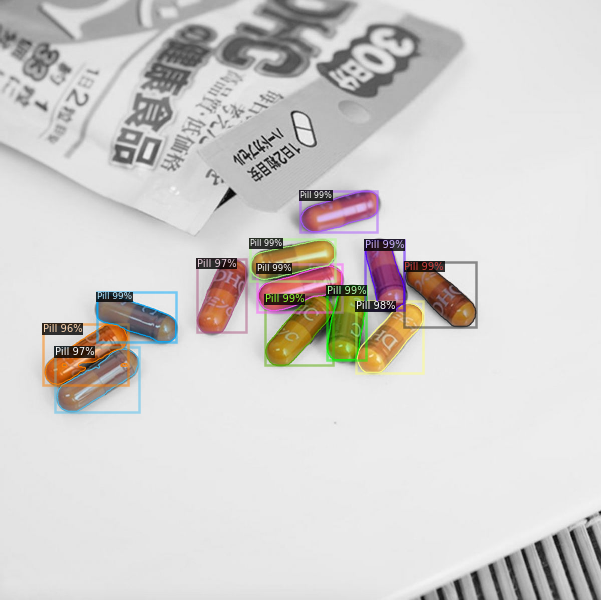

In [11]:
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
im = cv2.imread('/content/train_pill/2.jpg')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=pill_metadata, 
                scale=0.5, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow((v.get_image()[:, :, ::-1]))